# Tmn, computation
Notebook for computing $T_{mn}$ term in CSW equations
$$ T_{mn} = \int_{-H}^\bar{\eta} \phi_n \nabla \phi_m dz $$
Contains 2 methods:
1. Direct finite difference
2. Approximation based on pertubation analysis of the vertical modes: 
$$ \begin{align} T_{mn} &= \frac{1}{c_n^2-c_m^2}\left\lbrace 
                -\phi_n(-H)\phi_m(-H) c_n^2 \nabla_h H 
                + \int\varphi_n\varphi_m\nabla_h N^2 dz 
                + c_n^2c_m^2\frac{\phi(\bar\eta)}{g} \nabla_h\bar\eta \left( 
                    \frac{\nabla_hN^2(0)}{N^2(0)} + \frac{g}{c_n^2} + \frac{N^2(0)}{g} \right) 
                \right\rbrace, \quad n\neq m\\
   &= (1-\phi_n^2(-H)) \frac{\nabla_hH}{2} + 0 - \nabla_h\bar\eta \phi_n^2(\bar\eta), \quad n=m            \end{align} $$

In [1]:
%matplotlib inline   
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.figsize': (9, 8), "font.family": "serif", "font.size":14}) 

from pathlib import Path ### ordre des imports : par "thématique" et du plus standard au plus custom
import socket
import numpy as np

import xarray as xr
from xgcm import Grid


In [2]:
from dask.distributed import Client, LocalCluster, wait
host = socket.gethostname()
tmp_dir = Path.home()/"tmp" if host=="sverdrup" else Path("./")
cluster = LocalCluster(local_directory=tmp_dir)
client = Client(address=cluster)
client 


/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61296 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:61296/status,
Dashboard: http://127.0.0.1:61296/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61297,Workers: 4
Dashboard: http://127.0.0.1:61296/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:61314,Total threads: 4
Dashboard: http://127.0.0.1:61317/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:61303,


# Load data and set some parameters
* Load different dataset, re-organize and merge; 
* set chunking and other computational parameters

### Path of data

In [3]:
### Path of data used

if host == "sverdrup": 
    data_path = tmp_dir/"eNATL60"
    data_name = "grid_vmodes/eNATL60NOE_global-mean_grid-vmodes.zarr"
    mode_uv = {uv: f"grid_vmodes/eNATL60NOE_global-mean_vmodes_{uv}-grid.zarr" for uv in ["u","v"]}
    metr_xy = "grid_vmodes/eNATL60NOE_global-mean_vmodes_t-grid.zarr"
else: # config Adrien
    raise ValueError(f"path not set for this machine: {host}")
    
# path for storing output datasets
out_path = data_path
out_file = {"Tmn_findiff": "Tmn_findiff.zarr", 
            "Tmn_pert":"Tmn_pert.zarr",
            "Tmn_wrongdif": "Tmn_findiff_wrong.zarr"
           }


### Set computational parameters

In [4]:
### Chunking and spatial domain: set parameters
chk_h, chk_z = 300, 50
subdomain = False # True or False

ntom = {"mode":"modm"} # for conciseness

### Other stuff
store_kwgs = dict(consolidated=True, safe_chunks=True)
grav = 9.81 # should be read in dataset

### Load datasets

In [8]:
%%time 
### Load modes, grid and stratif, merging all three variables in a single dataset ("merge")
if isinstance(data_name, dict):
    ds = xr.merge([xr.open_zarr(data_path/f) for f in data_name.values()])
else:
    ds = xr.open_zarr(data_path/data_name)
if host == "sverdrup":
    dp = xr.open_zarr(data_path/mode_uv["u"])
    candv = list(dp.coords)+list(dp.data_vars)
    ds = ds.merge(dp.rename({v:v+"_u" for v in candv if "x_r" in dp[v].dims and v in ds}), compat="override")
    dp = xr.open_zarr(data_path/mode_uv["v"])
    candv = list(dp.coords)+list(dp.data_vars)
    ds = ds.merge(dp.rename({v:v+"_v" for v in candv if "y_r" in dp[v].dims and v in ds}), compat="override")
    ds = ds.merge(xr.open_zarr(data_path/metr_xy).get(["e1t", "e2t"]))
    
### put some of the variables as coordinates (mostly for clarity)
v_to_c = ["depth_c_3d", "depth_u_m", "depth_v_m", "depth_l_3d", 
          "e3t", "e3w", "tmask", "hbot", "e2t", "e2u", "e2v", "e1t", "e1u", "e1v"
         ]
ds = ds.set_coords([c for c in v_to_c if c in ds.data_vars])

# It is most likely simpler to have the whole dataset appropriatly chunked from the beginning
chking = {**{d:chk_h for d in ds.dims if d[0] in "xy"}, **{d:chk_z for d in ds.dims if d[0] =="z"}}
ds = ds.chunk(chking)

if subdomain: # subdomain is already a bool, no need to test it with  == True
    slix = slice(0, 200)
    sliy = slice(0, 200)
    ds = ds.isel(x_r=slix, y_c=sliy, x_c=slix, y_r=sliy)
    
xgrid = Grid(ds, periodic=None) 
dm = ds.rename({ntom})
ds

CPU times: user 1.49 s, sys: 158 ms, total: 1.65 s
Wall time: 8.28 s


<xarray.Dataset>
Dimensions:     (z_l: 300, y_c: 139, x_c: 121, mode: 11, z_c: 300, x_r: 121, y_r: 139)
Coordinates: (12/38)
    depth_c     (z_c) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    depth_c_3d  (z_c, y_c, x_c) float32 dask.array<chunksize=(50, 139, 121), meta=np.ndarray>
    depth_l     (z_l) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    depth_l_3d  (z_l, y_c, x_c) float32 dask.array<chunksize=(50, 139, 121), meta=np.ndarray>
    e3t         (z_c, y_c, x_c) float32 dask.array<chunksize=(50, 139, 121), meta=np.ndarray>
    e3w         (z_l, y_c, x_c) float32 dask.array<chunksize=(50, 139, 121), meta=np.ndarray>
    ...          ...
    llon_rc     (y_r, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    vmask       (z_c, y_r, x_c) int8 dask.array<chunksize=(50, 139, 121), meta=np.ndarray>
    vmaskutil   (y_r, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
  * y_r         (y_r) float32 1.438e+03 1.44e+03 ... 1.576e+03 1.576e+03
    e1t         (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e2t         (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
Data variables: (12/15)
    bvf         (z_l, y_c, x_c) float32 dask.array<chunksize=(50, 139, 121), meta=np.ndarray>
    c           (y_c, x_c, mode) float32 dask.array<chunksize=(139, 121, 1), meta=np.ndarray>
    norm        (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    phi         (y_c, x_c, z_c, mode) float32 dask.array<chunksize=(139, 121, 50, 1), meta=np.ndarray>
    phiw        (y_c, x_c, z_l, mode) float32 dask.array<chunksize=(139, 121, 50, 1), meta=np.ndarray>
    pres_m      (z_c, y_c, x_c) float32 dask.array<chunksize=(50, 139, 121), meta=np.ndarray>
    ...          ...
    phi_u       (y_c, x_r, z_c, mode) float32 dask.array<chunksize=(139, 121, 50, 11), meta=np.ndarray>
    phiw_u      (y_c, x_r, z_l, mode) float32 dask.array<chunksize=(139, 121, 50, 11), meta=np.ndarray>
    c_v         (y_r, x_c, mode) float32 dask.array<chunksize=(139, 121, 11), meta=np.ndarray>
    norm_v      (y_r, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    phi_v       (y_r, x_c, z_c, mode) float32 dask.array<chunksize=(139, 121, 50, 11), meta=np.ndarray>
    phiw_v      (y_r, x_c, z_l, mode) float32 dask.array<chunksize=(139, 121, 50, 11), meta=np.ndarray>
Attributes:
    date_processed:       2021-12-13T14:41
    from_files:           ['/scratch/cnt0024/ige2071/nlahaye/mesh_mask_eNATL6...
    processing notebook:  comp_mean_grid.ipynb
    simulation:           eNATL60
    time_end:             16
    time_start:           0

# Computing $T_{mn} \cdot H $

### Finite difference method, with proper discretisation
For the term that enters the momentum equation (through $\int \phi_n \nabla_h p dz$, hence a gradient, evaluated on the $(u,v)$ grid), one has:
$$ \delta_x^{(u)} p_n \gamma_n^{(u)} + \sum_m \overline{p_m}^{(u)} \int \phi_n^{(u)} \delta_x \phi_m^{(t)} dz^{(u)}
        + \sum_m \delta_x^{(u)} p_m \int \phi_n^{(u)}\left( \overline{\phi_m^{(t)}}^{(u)} - \phi_m^{(u)}\right) dz^{(u)}, $$
and likewise for the $y$-component. The first term is the gradient of the modal amplitude of pressure, the second term is the coupling due to variations of modes in the horizontal, and the last one is a correction due to interpolation issues with the vertical mode basis.

For the term that enters the continuity (hence, an horizontal divergence evaluated at $T$ points), one has $\int \phi_n\nabla_h u dz$ that gives:
$$ \frac{\delta_x(e_{2u} u_n)}{e_{1t} e_{2t}} \gamma_n^{(t)} 
    + \sum_m \frac{\overline{ e_{2u} u_m}^{(t)}}{e_{2t}} \int \frac{\delta_x(e_{3u} \phi_m^{(u)})}{e_{3t}e_{1t}}\phi_n^{(t)} dz
    + \sum_m \frac{\delta_x(e_{2u} u_m)}{e_{1t}e_{2t}} \int \phi_n^{(t)} \left( 
            \frac{\overline{ e_{3u}\phi_m^{(u)}}^{(t)}}{e_{3t}} - \phi_m^{(t)} \right) dz
,$$ following the same order as previously.

In the following, I will be only computing the mode-dependent part of the second and third terms

In [11]:
### Gradient
xkwg = dict(boundary="extrapolate")

Tmn = xr.Dataset()
Tmn["pgradp_x"] = ( xgrid.diff(dm.phi.where(dm.tmask, 0.), "X", **xkwg).chunk({"x_r":chk_h}) \
                      * ds.phi_u * ds.e3u).where(ds.umask).sum("z_c")
Tmn["pgradp_y"] = ( xgrid.diff(dm.phi.where(dm.tmask, 0.), "Y", **xkwg).chunk({"y_r":chk_h}) \
                      * ds.phi_v * ds.e3v).where(ds.vmask).sum("z_c")
Tmn["pgitp_x"] = ( ( xgrid.interp(dm.phi.where(dm.tmask, 0.), "X", **xkwg).chunk({"x_r":chk_h}) 
                      - dm.phi_u ) * ds.phi_u * ds.e3u
                 ).where(ds.umask).sum("z_c")
Tmn["pgitp_y"] = ( ( xgrid.interp(dm.phi.where(ds.tmask, 0.), "Y", **xkwg).chunk({"y_r":chk_h}) 
                      - dm.phi_v ) * ds.phi_v * ds.e3v
                 ).where(ds.vmask).sum("z_c")

%time Tmn.to_zarr(out_path/out_file["Tmn_findiff"], compute=True, mode="w", **store_kwgs)

CPU times: user 9.78 s, sys: 976 ms, total: 10.8 s
Wall time: 17.2 s


In [12]:
### divergence
Tmn["pdivp_x"] = ( xgrid.diff((dm.e3u * dm.phi_u).where(dm.umask, 0.), "X", **xkwg
                             ).chunk({"x_c":chk_h}) \
                    / ds.e1t * ds.phi ).where(ds.tmask).sum("z_c")
Tmn["pdivp_y"] = ( xgrid.diff((dm.e3v * dm.phi_v).where(dm.vmask, 0.), "Y", **xkwg
                             ).chunk({"y_c":chk_h}) \
                    / ds.e2t * ds.phi ).where(ds.tmask).sum("z_c")
Tmn["pditp_x"] = ( ( xgrid.interp((dm.e3u * dm.phi_u).where(dm.umask, 0.), "X", **xkwg
                               ).chunk({"x_c":chk_h}) - dm.phi * dm.e3t
                   ) * ds.phi ).where(ds.tmask).sum("z_c")
Tmn["pditp_y"] = ( ( xgrid.interp((dm.e3v * dm.phi_v).where(dm.vmask, 0.), "Y", **xkwg
                               ).chunk({"y_c":chk_h}) - dm.phi * dm.e3t
                   ) * ds.phi ).where(ds.tmask).sum("z_c")

### TO CHECK: not sure whether it is actually NOT recomputing the four previous terms. 
%time Tmn.to_zarr(out_path/out_file["Tmn_findiff"], compute=True, mode="a", **store_kwgs)

/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/array/core.py:4700: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/array/core.py:4700: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


CPU times: user 18.6 s, sys: 1.38 s, total: 19.9 s
Wall time: 25 s


In [14]:
out_path/out_file["Tmn_findiff"]

PosixPath('/Users/nlahaye/tmp/eNATL60/Tmn_findiff.zarr')

2022-08-10 08:00:06,499 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:61312', name: 3, status: running, memory: 0, processing: 0>
2022-08-10 08:00:06,583 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:61314', name: 0, status: running, memory: 0, processing: 0>
2022-08-10 08:00:06,619 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:61312'.
2022-08-10 08:00:06,621 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:61314'.
2022-08-10 08:00:06,639 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:61312'. Shutting down.
2022-08-10 08:00:06,645 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:61314'. Shutting down.

Traceback (most recent call last):
  File "/opt/miniconda3/envs/x

In [24]:
### Plot result for verification: both components + norm
dr = xr.open_zarr(out_path/out_file["Tmn_findiff"])
dr # check that it seems correct

<xarray.Dataset>
Dimensions:    (y_c: 139, x_c: 121, x_r: 121, y_r: 139, mode: 11, modm: 11)
Coordinates: (12/16)
    e1t        (y_c, x_c) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    e2t        (y_c, x_c) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    hbot       (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    hbot_u     (y_c, x_r) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    hbot_v     (y_r, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    ...         ...
    umaskutil  (y_c, x_r) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    vmaskutil  (y_r, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
  * x_c        (x_c) int64 4014 4015 4016 4017 4018 ... 4130 4131 4132 4133 4134
  * x_r        (x_r) float64 4.014e+03 4.016e+03 ... 4.134e+03 4.134e+03
  * y_c        (y_c) int64 1438 1439 1440 1441 1442 ... 1572 1573 1574 1575 1576
  * y_r        (y_r) float64 1.438e+03 1.44e+03 1.44e+03 ... 1.576e+03 1.576e+03
Data variables:
    pditp_x    (y_c, x_c, modm, mode) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    pditp_y    (y_c, x_c, modm, mode) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    pdivp_x    (y_c, x_c, modm, mode) float32 dask.array<chunksize=(139, 121, 11, 1), meta=np.ndarray>
    pdivp_y    (y_c, x_c, modm, mode) float32 dask.array<chunksize=(139, 121, 11, 1), meta=np.ndarray>
    pgitp_x    (y_c, x_r, modm, mode) float32 dask.array<chunksize=(139, 121, 1, 11), meta=np.ndarray>
    pgitp_y    (y_r, x_c, modm, mode) float32 dask.array<chunksize=(139, 121, 1, 11), meta=np.ndarray>
    pgradp_x   (y_c, x_r, mode) float32 dask.array<chunksize=(139, 121, 1), meta=np.ndarray>
    pgradp_y   (y_r, x_c, mode) float32 dask.array<chunksize=(139, 121, 1), meta=np.ndarray>

Text(0.5, 0.97, '$T_{mn}$ terms, finite difference: $n=1, m=3$')

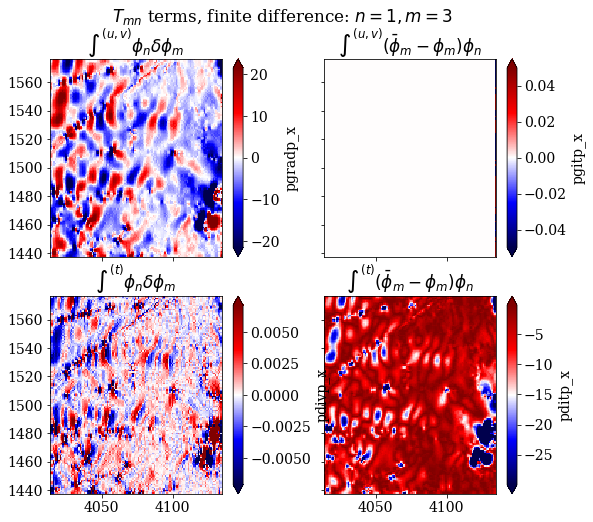

In [27]:
mode, modm = 1, 3
dim = "x"

sdr = dr.sel(mode=mode, modm=modm)

#amp = (sdr.Tmn_x.std() + sdr.Tmn_y.std()).values
plt_kwg = dict(cmap="seismic", robust=True) #vmin=-amp, vmax=amp, add_colorbar=False)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
ax = axs[0,0]
hpl = sdr[f"pgradp_{dim}"].plot(ax=ax, **plt_kwg)
ax.set_title(r"$\int^{(u,v)} \phi_n \delta \phi_m$")
ax = axs[0,1]
sdr[f"pgitp_{dim}"].plot(ax=ax, **plt_kwg)
ax.set_title(r"$\int^{(u,v)} (\bar\phi_m-\phi_m)\phi_n$")
ax = axs[1,0]
hpl = sdr[f"pdivp_{dim}"].plot(ax=ax, **plt_kwg)
ax.set_title(r"$\int^{(t)} \phi_n \delta \phi_m$")
ax = axs[1,1]
sdr[f"pditp_{dim}"].plot(ax=ax, **plt_kwg)
ax.set_title(r"$\int^{(t)} (\bar\phi_m-\phi_m)\phi_n$")

for ax in axs.ravel():
    ax.set_aspect(1)
    ax.set_xlabel("")
    ax.set_ylabel("")
#fig.subplots_adjust(right=.95)
#cbar_ax = fig.add_axes([.96, .3, 0.02, .4])
#ac = fig.colorbar(hpl, cax=cbar_ax, extend="both", label="")

fig.suptitle(r"$T_{mn}$ terms, finite difference: "+fr"$n={mode}, m={modm}$", y=.97)

### Finite difference method: wrong version

In [19]:
%%time
### First method based on direct finite difference
Phim = ds.phi.rename({"mode":"modm"})

Phimx = xgrid.diff(Phim, 'X', boundary="extend").chunk({"x_r":chk_h})
Phimy = xgrid.diff(Phim, 'Y', boundary="extend").chunk({"y_r":chk_h})

Phimx = xgrid.interp(Phimx, "X", boundary="extend").chunk({"x_c":chk_h})/ds.e1t
Phimy = xgrid.interp(Phimy, "Y", boundary="extend").chunk({"y_c":chk_h})/ds.e2t

Tmn_x = (ds.phi * Phimx * ds.e3t).sum("z_c") 
Tmn_y = (ds.phi * Phimy * ds.e3t).sum("z_c") 

# Store result
Tmn_x.to_dataset(name="Tmn_x").to_zarr(out_path/out_file["Tmn_wrongdif"], compute=True, mode="w", **store_kwgs)
Tmn_y.to_dataset(name="Tmn_y").to_zarr(out_path/out_file["Tmn_wrongdif"], compute=True, mode="a", **store_kwgs)

/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/array/core.py:4700: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/array/core.py:4700: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


CPU times: user 8.27 s, sys: 562 ms, total: 8.83 s
Wall time: 11.1 s


In [11]:
### Plot result for verification: both components + norm
dr = xr.open_zarr(out_path/out_file["Tmn_wrongdif"])
dr # check that it seems correct

<xarray.Dataset>
Dimensions:    (y_c: 139, x_c: 121, mode: 11, modm: 11)
Coordinates:
    e1t        (y_c, x_c) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    e2t        (y_c, x_c) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    hbot       (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * modm       (modm) int64 0 1 2 3 4 5 6 7 8 9 10
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
  * x_c        (x_c) int64 4014 4015 4016 4017 4018 ... 4130 4131 4132 4133 4134
  * y_c        (y_c) int64 1438 1439 1440 1441 1442 ... 1572 1573 1574 1575 1576
Data variables:
    Tmn_x      (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_y      (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>

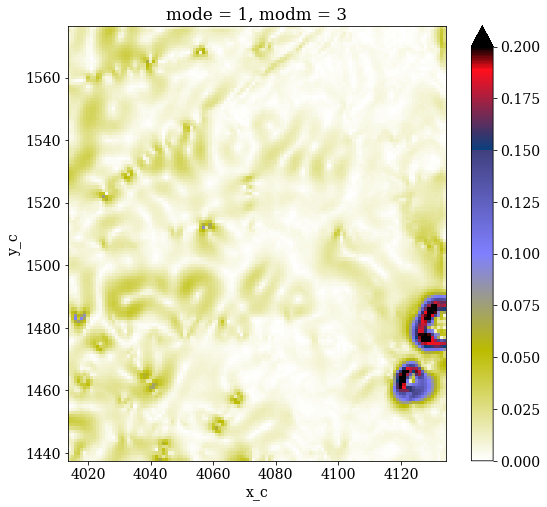

In [14]:
data = np.sqrt(dr.Tmn_x**2 + dr.Tmn_y**2).isel(mode=a, modm=b)
amp = 2e-1
hpl = data.plot(cmap="gist_stern_r", vmin=0, vmax=amp, cbar_kwargs={"label":""})
hpl.axes.set_aspect(1)

### Tmn*H stratification perturbation

In [15]:
%%time

Bx = (ds.bvf.differentiate("x_c")).chunk({"x_c":chk_h})/ds.e1t
By = (ds.bvf.differentiate("y_c")).chunk({"y_c":chk_h})/ds.e2t

Tmn_x = ( ds.phiw * ds.phiw.rename(ntom) ) * Bx / ( ds.c**2 - ds.c.rename(ntom)**2 )
Tmn_y = ( ds.phiw * ds.phiw.rename(ntom) ) * By / ( ds.c**2 - ds.c.rename(ntom)**2 )

Tmn = (xr.merge([Tmn_x.rename("Tmn_Nx"), Tmn_y.rename("Tmn_Ny")]) * ds.e3w).sum("z_l") 
Tmn = Tmn.where(Tmn.mode!=Tmn.modm, 0.) # diagonal terms are 0.
    
# store result
Tmn.to_zarr(out_path/out_file["Tmn_pert"], compute=True, mode='w', **store_kwgs)

/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/array/core.py:4700: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/array/core.py:4700: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/array/core.py:4700: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/array/core.py:4700: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_ex

CPU times: user 9.24 s, sys: 957 ms, total: 10.2 s
Wall time: 17.3 s


In [16]:
### check and plot
dr = xr.open_zarr(out_path/out_file["Tmn_pert"])
dr # check the structure of the result

<xarray.Dataset>
Dimensions:    (y_c: 139, x_c: 121, mode: 11, modm: 11)
Coordinates:
    e1t        (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e2t        (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    hbot       (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * modm       (modm) int64 0 1 2 3 4 5 6 7 8 9 10
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
  * x_c        (x_c) int64 4014 4015 4016 4017 4018 ... 4130 4131 4132 4133 4134
  * y_c        (y_c) int64 1438 1439 1440 1441 1442 ... 1572 1573 1574 1575 1576
Data variables:
    Tmn_Nx     (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Ny     (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>

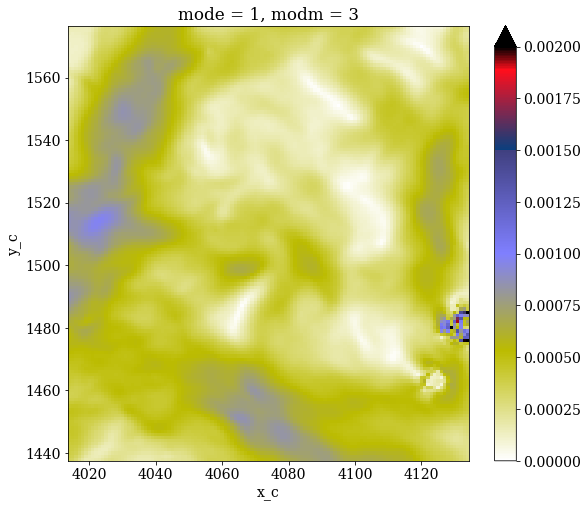

In [19]:
data = np.sqrt(dr.Tmn_Nx**2 + dr.Tmn_Ny**2).isel(mode=a, modm=b)

amp = 2e-3
im = data.plot(cmap="gist_stern_r", vmin=0, vmax=amp, 
               cbar_kwargs={"label":""}
              )
hpl.axes.set_aspect(1)

### Tmn*H topographic perturbation

In [20]:
%%time

Hx = ds.hbot.differentiate("x_c").chunk({"x_c":chk_h}) / ds.e1t
Hy = ds.hbot.differentiate("y_c").chunk({"y_c":chk_h}) / ds.e2t

# Find index of bottom
indz = ds.tmask.sum("z_c").reset_coords(drop=True)
indz = indz.where(indz>0, ds.z_c.size) # trick to get Nan on land
phibot = ds.phi.reset_coords(drop=True).sel(z_c=indz).persist()

wrk = ds.c**2 / (ds.c.rename(ntom)**2 - ds.c**2) * phibot * phibot.rename(ntom)
Tmn_x = wrk.where(wrk.mode!=wrk.modm, 0.5*(1-phibot**2)) * Hx
Tmn_y = wrk.where(wrk.mode!=wrk.modm, 0.5*(1-phibot**2)) * Hy

Tmn = xr.merge([Tmn_x.rename("Tmn_Hx"), Tmn_y.rename("Tmn_Hy")])
   
# store result
Tmn.to_zarr(out_path/out_file["Tmn_pert"], compute=True, mode='a', **store_kwgs)

/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/array/core.py:4700: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


CPU times: user 2.72 s, sys: 166 ms, total: 2.89 s
Wall time: 4.07 s


In [21]:
### check and plot
dr = xr.open_zarr(out_path/out_file["Tmn_pert"])
dr # check the structure of the result

<xarray.Dataset>
Dimensions:    (y_c: 139, x_c: 121, mode: 11, modm: 11)
Coordinates:
    e1t        (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e2t        (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    hbot       (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * modm       (modm) int64 0 1 2 3 4 5 6 7 8 9 10
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
  * x_c        (x_c) int64 4014 4015 4016 4017 4018 ... 4130 4131 4132 4133 4134
  * y_c        (y_c) int64 1438 1439 1440 1441 1442 ... 1572 1573 1574 1575 1576
    z_c        (y_c, x_c) int64 dask.array<chunksize=(139, 121), meta=np.ndarray>
Data variables:
    Tmn_Hx     (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Hy     (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Nx     (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Ny     (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>

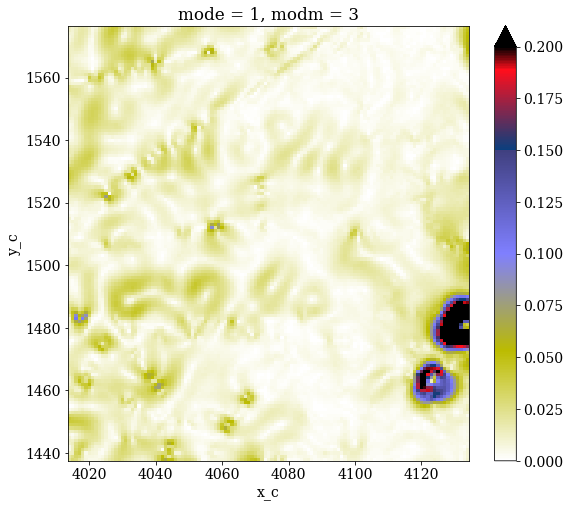

In [23]:
data = np.sqrt(dr.Tmn_Hx**2 + dr.Tmn_Hy**2).isel(mode=a, modm=b)

amp = 2e-1
im = data.plot(cmap="gist_stern_r", vmin=0, vmax=amp, 
               cbar_kwargs={"label":""}
              )

### TMN*H surface contribution

In [24]:
%%time

phisurf = ds.phi.isel(z_c=0)
phiwsurf = ds.phiw.isel(z_l=0)
Nsurf = ds.bvf.isel(z_l=0)

Ex = ds.sossheig.differentiate("x_c").chunk({"x_c":chk_h}) / ds.e1t
Ey = ds.sossheig.differentiate("y_c").chunk({"y_c":chk_h}) / ds.e2t
Nx = Nsurf.differentiate("x_c").chunk({"x_c":chk_h}) / ds.e1t
Ny = Nsurf.differentiate("y_c").chunk({"y_c":chk_h}) / ds.e2t

cm = ds.c.rename(ntom) # better call it "cm" for clarity
wrk = ds.c**2 * cm**2 / (ds.c**2-cm**2) * phisurf / grav
Tmn_x = wrk * ( Nx/Nsurf + grav/ds.c**2 + Nsurf/grav )
Tmn_y = wrk * ( Ny/Nsurf + grav/ds.c**2 + Nsurf/grav )

#for n=m.
Tmn_x = (-phisurf**2).where(Tmn_x.mode == Tmn_x.modm, Tmn_x) * Ex
Tmn_y = (-phisurf**2).where(Tmn_y.mode == Tmn_y.modm, Tmn_y) * Ey
    
Tmn = xr.merge([Tmn_x.rename("Tmn_Sx"), Tmn_y.rename("Tmn_Sy")])
Tmn = Tmn.reset_coords([c for c in Tmn.coords if len(Tmn[c].dims)==0], drop=True)

# store result
Tmn.to_zarr(out_path/out_file["Tmn_pert"], compute=True, mode='a', **store_kwgs)

/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/array/core.py:4700: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/dask/array/core.py:4700: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


CPU times: user 1.49 s, sys: 128 ms, total: 1.62 s
Wall time: 2.72 s


In [25]:
### check and plot
dr = xr.open_zarr(out_path/out_file["Tmn_pert"])
dr # check the structure of the result

<xarray.Dataset>
Dimensions:     (y_c: 139, x_c: 121, mode: 11, modm: 11)
Coordinates: (12/16)
    depth_c_3d  (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    depth_l_3d  (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e1t         (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e2t         (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3t         (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3w         (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    ...          ...
  * modm        (modm) int64 0 1 2 3 4 5 6 7 8 9 10
    tmask       (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
  * x_c         (x_c) int64 4014 4015 4016 4017 4018 ... 4131 4132 4133 4134
  * y_c         (y_c) int64 1438 1439 1440 1441 1442 ... 1573 1574 1575 1576
    z_c         (y_c, x_c) int64 dask.array<chunksize=(139, 121), meta=np.ndarray>
Data variables:
    Tmn_Hx      (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Hy      (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Nx      (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Ny      (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Sx      (y_c, x_c, mode, modm) float64 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Sy      (y_c, x_c, mode, modm) float64 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>

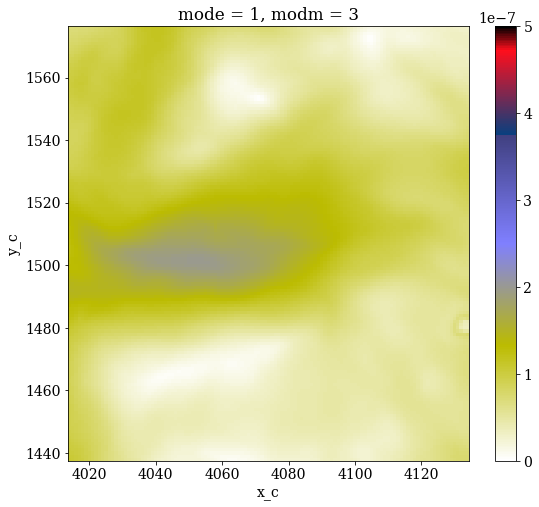

In [29]:
data = np.sqrt(dr.Tmn_Sx**2 + dr.Tmn_Sy**2).isel(mode=a, modm=b)

amp = 5e-7
im = data.plot(cmap="gist_stern_r", vmin=0, vmax=amp, 
               cbar_kwargs={"label":""}
              )
hpl.axes.set_aspect(1)

# Verifications: how different are the two methods?

In [30]:
dr = xr.merge([xr.open_zarr(out_path/f) for f in out_file.values()])
dr


<xarray.Dataset>
Dimensions:     (y_c: 139, x_c: 121, mode: 11, modm: 11)
Coordinates: (12/16)
    e1t         (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e2t         (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    hbot        (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llat_cc     (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llon_cc     (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
  * mode        (mode) int64 0 1 2 3 4 5 6 7 8 9 10
    ...          ...
    depth_c_3d  (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    depth_l_3d  (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3t         (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3w         (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    tmask       (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    z_c         (y_c, x_c) int64 dask.array<chunksize=(139, 121), meta=np.ndarray>
Data variables:
    Tmn_x       (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_y       (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Hx      (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Hy      (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Nx      (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Ny      (y_c, x_c, mode, modm) float32 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Sx      (y_c, x_c, mode, modm) float64 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>
    Tmn_Sy      (y_c, x_c, mode, modm) float64 dask.array<chunksize=(139, 121, 1, 1), meta=np.ndarray>

Text(0.5, 0.97, '$T_{mn}$ term, comparison: $n=3, m=4$')

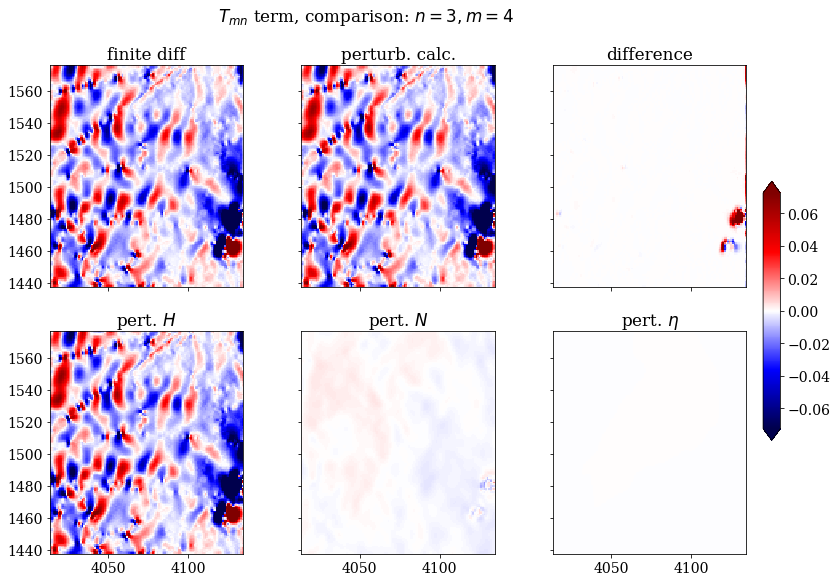

In [45]:
mode, modm = 3, 4
dim = "x"

sdr = dr.sel(mode=mode, modm=modm)
amp = (sdr.Tmn_x.std() + sdr.Tmn_y.std()).values
plt_kwg = dict(cmap="seismic", vmin=-amp, vmax=amp, add_colorbar=False)
Tmn = sdr[f"Tmn_H{dim}"] - sdr[f"Tmn_N{dim}"] + sdr[f"Tmn_S{dim}"]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,9))
ax = axs[0,0]
hpl = sdr[f"Tmn_{dim}"].plot(ax=ax, **plt_kwg)
ax.set_title("finite diff")
ax = axs[0,1]
Tmn.plot(ax=ax, **plt_kwg)
ax.set_title("perturb. calc.")
ax = axs[0,2]
(sdr[f"Tmn_{dim}"] - Tmn).plot(ax=ax, **plt_kwg)
ax.set_title("difference")
ax = axs[1,0]
sdr[f"Tmn_H{dim}"].plot(ax=ax, **plt_kwg)
ax.set_title(r"pert. $H$")
ax = axs[1,1]
sdr[f"Tmn_N{dim}"].plot(ax=ax, **plt_kwg)
ax.set_title(r"pert. $N$")
ax = axs[1, 2]
sdr[f"Tmn_S{dim}"].plot(ax=ax, **plt_kwg)
ax.set_title(r"pert. $\eta$")

for ax in axs.ravel():
    ax.set_aspect(1)
    ax.set_xlabel("")
    ax.set_ylabel("")
fig.subplots_adjust(right=.95)
cbar_ax = fig.add_axes([.96, .3, 0.02, .4])
ac = fig.colorbar(hpl, cax=cbar_ax, extend="both", label="")

fig.suptitle(r"$T_{mn}$ term, comparison: "+fr"$n={mode}, m={modm}$", y=.97)